### Convolution Network 시각화
- 중간층 활성화 시각화 
  - 각 층에서 입력을 어떻게 바꾸는지
  - 개별적인 convnet filter의 의미 파악
  
- convnet filter 시각화
  - convnet이 찾으려는 시각적인 패턴과 개념이 무엇인지 이해
  
- 클래스 활성화에 대한 히트맵을 이미지에 시각화
  - 이미지의 어느 부분이 해당 클래스에 속하는데 기여했는지 이해
  - 객체의 위치를 추정

In [2]:
from keras.models import load_model
model = load_model(filepath='cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [4]:
# training에 사용하지 않은 이미지 선택
img_path = 'datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(path=img_path, target_size=(150,150))
img_tensor = image.img_to_array(img=img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 첫번째 차원은 batch size라는 점을 고려한다.
img_tensor = img_tensor / 255.

print(img_tensor.shape)

(1, 150, 150, 3)


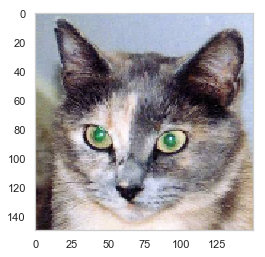

In [6]:
# 그려보자
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.grid(False)
plt.show()

In [9]:
# 입력 이미지에 대해 각 층에서의 출력값을 뽑는 모델을 만들자
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개 층만 선택
activation_model = models.Model(inputs=model.input, output=layer_outputs) # 입력이미지가 들어가면, 상위 8개층의 개별 출력을 낸다.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  """


In [12]:
activation = activation_model.predict(img_tensor)
# activation은 각 층별 출력값이므로 리스트 안에 8개가 들어있을것이다.
len(activation)

8

In [13]:
# 첫번째 layer의 활성화값을 보자
first_layer_activation = activation[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


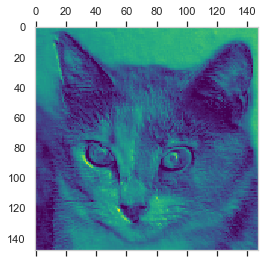

In [16]:
# 채널이 32개나 되기때문에 
# 다시말해 feature map이 32개나 된다.
# 그 중에서 20번째를 그려보자
plt.matshow(first_layer_activation[0,:,:,19], cmap='viridis')
plt.grid(False)
plt.show()

뭘 딴거지? 눈아래와 코 아래쪽 엣지?

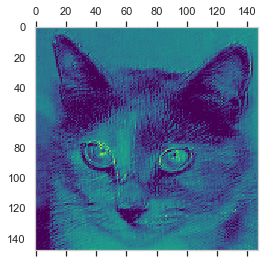

In [17]:
# 16번째꺼
plt.matshow(first_layer_activation[0,:,:,15], cmap='viridis')
plt.grid(False)
plt.show()

눈 / 귀 엣지 검출한거 같기도...<br>
눈과 귀를 인코딩할때 좋을 거 같다.

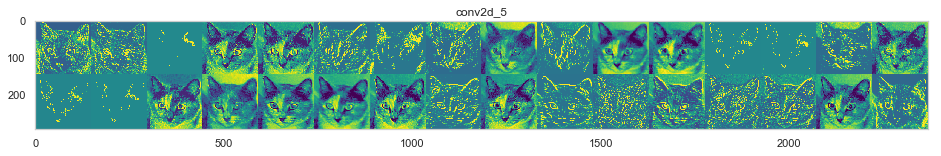

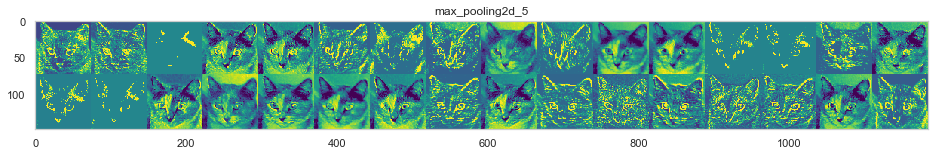

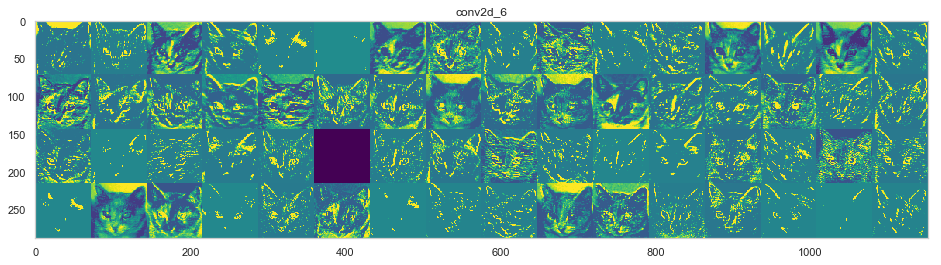

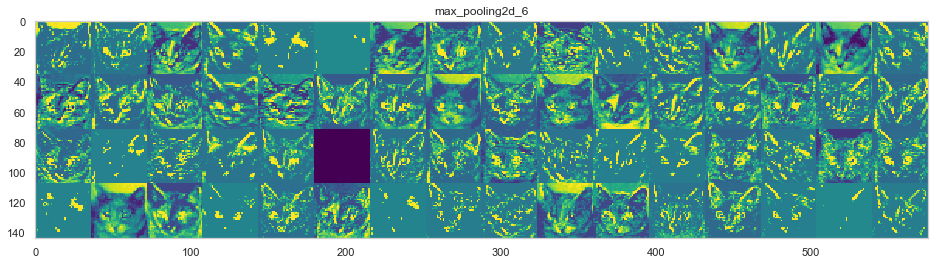

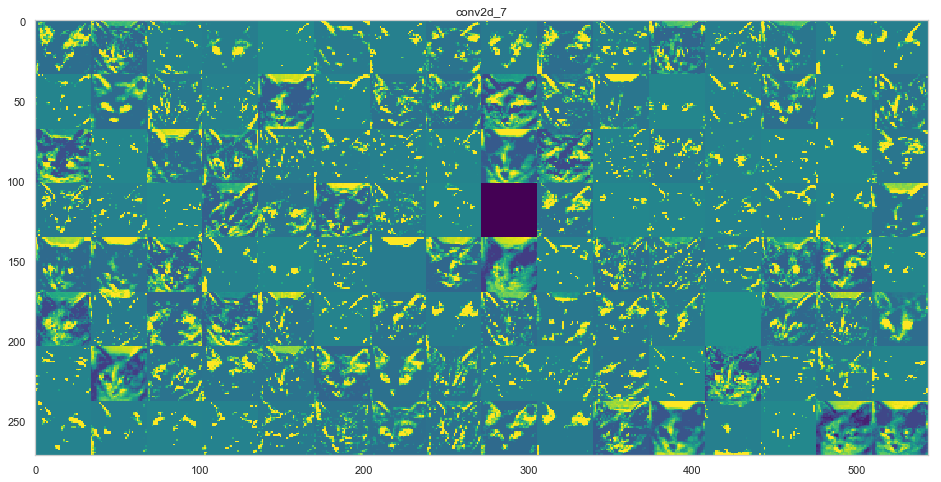

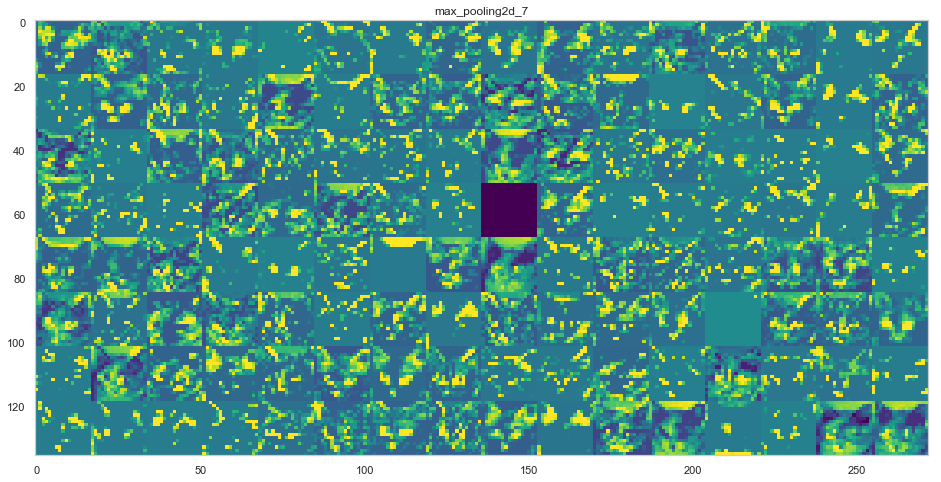

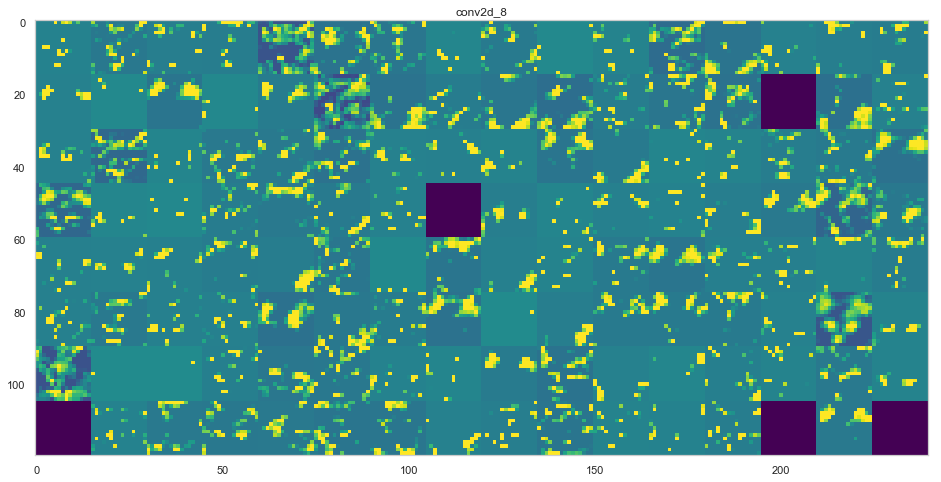

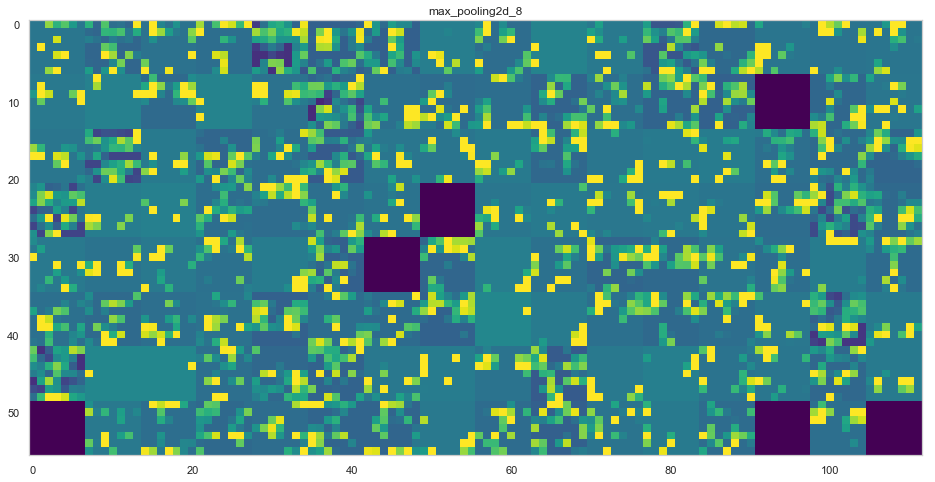

In [30]:
# 모든 활성화 채널 시작화하자
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16 # 한 행에 이미지 몇개 놓을거냐

for layer_name, layer_activation in zip(layer_names, activation):
    n_features = layer_activation.shape[-1] # feature / feature map 갯수
    size = layer_activation.shape[1] # ? x ? 인지 묻는 것, 고로 2로해도 같음
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row): #(0,0) ~ ((1,15))까지
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            
            # 그래프로 나타내기 좋게 특성을 처리한다는데... 잘모르겟다...
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1)*size, row * size : (row + 1)*size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

In [33]:
# convnet filter 시각화
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [34]:
gradient = K.gradients(loss=loss, variables=model.input)[0]

In [35]:
# gradient 정규화 
# gradient assent과정을 부드럽게 해주기위해 사용하는 기법
# gradient tensor를 L2 norm으로 나누어 정규화
# 이걸 gradient clipping이라 한다.
gradient /= (K.sqrt(K.mean(K.square(gradient))) + 1e-5) # 0 나눗셈을 막기 위해 1e-5를 넣어준다.

In [36]:
iterate = K.function(inputs=[model.input], outputs=[loss, gradient])

loss_value, gradient_vale = iterate([np.zeros((1,150,150,3))])

In [39]:
input_img_data = np.random.random((1,150,150,3)) * 20 * 128. # noise 일부러 추가, noise가 섞인 회색 이미지로 시작

step = 1. # step size
for i in range(40): # gradient assent 40회 실시
    loss_value, gradient_value = iterate([input_img_data])
    input_img_data += step*gradient_value